In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import json
import requests
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import geocoder
import time
import folium 

In [2]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
wikipedia_page = requests.get(wikipedia_link, headers = None)

In [3]:
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [4]:
rows = table.find_all('tr')

In [5]:
columns = ['Location','London borough','Post town','Postcode district','Dial code','OS grid ref']

In [6]:
df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [7]:
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    

    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text, tds[3].text, tds[4].text, tds[5].text, tds[6].text]
    else:
        values = [td.text for td in tds]
        df = df.append(pd.Series(values, index = columns), ignore_index = True)
        df

In [8]:
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [2]",LONDON,SE2,020,TQ465785\n
1,Acton,"Ealing, Hammersmith and Fulham[3]",LONDON,"W3, W4",020,TQ205805\n
2,Addington,Croydon[3],CROYDON,CR0,020,TQ375645\n
3,Addiscombe,Croydon[3],CROYDON,CR0,020,TQ345665\n
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728\n


In [9]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London borough': 'Borough', 'Post town': 'Post-town', 'Postcode district': 'Postcode', 'Dial code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [10]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [2]",LONDON,SE2,020,TQ465785\n
1,Acton,"Ealing, Hammersmith and Fulham[3]",LONDON,"W3, W4",020,TQ205805\n
2,Addington,Croydon[3],CROYDON,CR0,020,TQ375645\n
3,Addiscombe,Croydon[3],CROYDON,CR0,020,TQ345665\n
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728\n


In [11]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [12]:
df.head()

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785\n
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805\n
2,Addington,Croydon,CROYDON,CR0,020,TQ375645\n
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665\n
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728\n


In [13]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [14]:
df0.head()

,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785\n,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805\n,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805\n,W4
10,Angel,Islington,LONDON,020,TQ345665\n,EC1
10,Angel,Islington,LONDON,020,TQ345665\n,N1


In [15]:
df0.shape

(638, 6)

In [16]:
df1 = df0[['Location','Borough','Postcode','Post-town']].reset_index(drop=True)

In [17]:
df1.head(10)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON
5,Church End,Brent,NW10,LONDON
6,Church End,Barnet,N3,LONDON
7,Clapham,"Lambeth, Wandsworth",SW4,LONDON
8,Clerkenwell,Islington,EC1,LONDON
9,Cockfosters,"Barnet, Enfield",EN4,BARNET


In [18]:
df1.shape

(638, 4)

In [19]:
df2 = df1
df2 = df2[df2['Post-town'].str.contains('LONDON')]

In [20]:
df2.shape

(380, 4)

In [21]:
df3 = df2[['Location','Borough','Postcode']].reset_index(drop=True)

In [22]:
df3.head()

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


According to the proportion of races by London borough as seen in  <a href="https://en.wikipedia.org/wiki/Indian_community_of_London">Demography of London</a>
, the top 10 Indian Regions are shown below:

In [23]:
df4 = pd.read_csv('Indian_Londoncsv.csv')

In [24]:
df4

,Borough,Indian
0,Harrow,26.4
1,Hounslow,19.0
2,Brent,18.6
3,Rebridge,16.4
4,Ealing,14.3
5,Newham,13.8
6,Hillingdon,13.4
7,Greater London,6.6


Text(0,0.5,'% population')

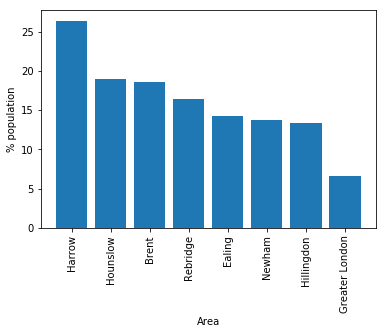

In [25]:
plt.bar(df4['Borough'],df4['Indian'])
plt.xticks( rotation = 90)
plt.xlabel('Area')
plt.ylabel('% population')

In [26]:
df_indian_top = df3[df3['Borough'].isin(['Harrow','Hounslow','Brent','Rebridge','Ealing','Newham','Hillington','Greater London','Barnet'])].reset_index(drop = True)

In [27]:
df_indian_top.head()

,Location,Borough,Postcode
0,Church End,Brent,NW10
1,Church End,Barnet,N3
2,Colindale,Barnet,NW9
3,Colney Hatch,Barnet,N11
4,Colney Hatch,Barnet,N10


In [28]:
def get_latlng(arcgis_geocoder):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [29]:
sample = get_latlng('NW10')
sample

[51.53916000000004, -0.2512299999999641]

In [30]:
start = time.time()

postal_codes = df_indian_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  134.33652663230896 seconds


In [31]:
df_indian_loc = df_indian_top

df_indian_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_indian_loc['Latitude'] = df_indian_coordinates['Latitude']
df_indian_loc['Longitude'] = df_indian_coordinates['Longitude']

In [32]:
df_indian_loc.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Church End,Brent,NW10,51.53916,-0.25123
1,Church End,Barnet,N3,51.60104,-0.19401
2,Colindale,Barnet,NW9,51.58486,-0.24881
3,Colney Hatch,Barnet,N11,51.61631,-0.13841
4,Colney Hatch,Barnet,N10,51.59107,-0.14852


In [33]:
df_indian_loc.to_csv('IndiaLondonLocationsCoordinates.csv', index = False)

In [34]:
df_indian_loc.shape

(71, 5)

In [35]:
#FourSquare Credentials
CLIENT_ID = 'KN0SRH2RHZ3HJRVQSH1BOQHLJ4ESYWSIC53QYCFXRQJSA5UW' # your Foursquare ID
CLIENT_SECRET = 'HBAAOTNXALQYM4JSCEJ1E2H4D3NXRNWGFU3IZG21UIDJIBHI' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KN0SRH2RHZ3HJRVQSH1BOQHLJ4ESYWSIC53QYCFXRQJSA5UW
CLIENT_SECRET:HBAAOTNXALQYM4JSCEJ1E2H4D3NXRNWGFU3IZG21UIDJIBHI


In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
venues = getNearbyVenues(names=df_indian_loc['Location'],
                                   latitudes=df_indian_loc['Latitude'],
                                   longitudes=df_indian_loc['Longitude']
                                  )

Church End
Church End
Colindale
Colney Hatch
Colney Hatch
Custom House
Dollis Hill
Arkley
Arkley
Ealing
Ealing
East Finchley
East Ham
Finchley
Finchley
Finchley
Forest Gate
Friern Barnet
Golders Green
Grahame Park
Grove Park
Gunnersbury
The Hale
Hampstead Garden Suburb
Hanwell
Harlesden
Hendon
Barnet Gate
Barnet Gate
The Hyde
Kensal Green
Kensal Green
Kingsbury
Little Ilford
Manor Park
Beckton
Beckton
Beckton
Maryland
Mill Hill
Neasden
Neasden
New Southgate
North Finchley
Bedford Park
North Woolwich
Oakleigh Park
Osidge
Plaistow
Queen's Park
Silvertown
Stonebridge
Stratford
Totteridge
Upton Park
Upton Park
West Ealing
West Ham
West Ham
West Hendon
Whetstone
Willesden
Woodside Park
Brent Cross
Brent Cross
Brent Park
Brondesbury
Brunswick Park
Burroughs, The
Canning Town
Childs Hill


In [38]:
len(venues)

2130

In [39]:
venues['Neighbourhood'].value_counts()
venues.to_csv('venues.csv')

In [40]:
venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Church End,51.53916,-0.25123,Beit El Zaytoun,51.534330,-0.261639,Middle Eastern Restaurant
1,Church End,51.53916,-0.25123,Rubio,51.537217,-0.241696,Pizza Place
2,Church End,51.53916,-0.25123,Grand Junction Arms,51.534325,-0.260390,Pub
3,Church End,51.53916,-0.25123,Centro Galego,51.532234,-0.236863,Spanish Restaurant
4,Church End,51.53916,-0.25123,Al Enam,51.526263,-0.258367,Middle Eastern Restaurant


In [41]:
venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Arkley,60,60,60,60,60,60
Barnet Gate,60,60,60,60,60,60
Beckton,90,90,90,90,90,90
Bedford Park,30,30,30,30,30,30
Brent Cross,60,60,60,60,60,60
Brent Park,30,30,30,30,30,30
Brondesbury,30,30,30,30,30,30
Brunswick Park,30,30,30,30,30,30
"Burroughs, The",30,30,30,30,30,30


In [42]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 130 uniques categories.


In [43]:
venue_unique_count = venues['Venue Category'].value_counts().to_frame(name='Count')

In [95]:
venue_unique_count.head(7)

,Count
Pub,171
Coffee Shop,146
Café,125
Park,111
Grocery Store,77
Indian Restaurant,75
Hotel,71


In [45]:
venue_unique_count.describe()

,Count
count,130.000000
mean,16.384615
std,26.839859
min,1.000000
25%,4.000000
50%,6.500000
75%,17.000000
max,171.000000


# Plotting the Map of London

In [46]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [47]:
# df_london_map
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

In [48]:
# Adding markers to map
for lat, lng, borough, loc in zip(df_indian_loc['Latitude'], 
                                  df_indian_loc['Longitude'],
                                  df_indian_loc['Borough'],
                                  df_indian_loc['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [49]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix = "", prefix_sep = "")

In [50]:
onehot['Neighbourhood'] = venues['Neighbourhood']

In [51]:
onehot.head()

,American Restaurant,Argentinian Restaurant,Art Gallery,Athletics & Sports,Bakery,Bar,Beer Bar,Bistro,Bookstore,Brasserie,...,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Church End
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Church End
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Church End
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Church End
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Church End


In [52]:
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])

onehot = onehot[fixed_columns]

In [53]:
onehot

,Neighbourhood,American Restaurant,Argentinian Restaurant,Art Gallery,Athletics & Sports,Bakery,Bar,Beer Bar,Bistro,Bookstore,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo
0,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
onehot.loc[onehot['Indian Restaurant'] != 0]

,Neighbourhood,American Restaurant,Argentinian Restaurant,Art Gallery,Athletics & Sports,Bakery,Bar,Beer Bar,Bistro,Bookstore,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo
14,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,Colney Hatch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
215,Arkley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
252,Arkley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
327,Ealing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
333,East Finchley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
335,East Finchley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
363,East Ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364,East Ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
onehot.loc[onehot['Neighbourhood'] == 'The Hale']

,Neighbourhood,American Restaurant,Argentinian Restaurant,Art Gallery,Athletics & Sports,Bakery,Bar,Beer Bar,Bistro,Bookstore,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo
660,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
661,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
662,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
663,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
664,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
665,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
666,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
667,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
668,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
669,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As can be seen from above, THE HALE with its demography has only 1 Indian Restaurant

In [56]:
onehot.to_csv('london_onehot.csv', index = False)

In [57]:
onehot.shape

(2130, 131)

In [58]:
grouped = onehot.groupby('Neighbourhood').mean().reset_index()
grouped.head()

,Neighbourhood,American Restaurant,Argentinian Restaurant,Art Gallery,Athletics & Sports,Bakery,Bar,Beer Bar,Bistro,Bookstore,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo
0,Arkley,0.0,0.016667,0.000000,0.016667,0.033333,0.000000,0.0,0.0,0.016667,...,0.000000,0.0,0.000000,0.0,0.016667,0.016667,0.0,0.0,0.0,0.0
1,Barnet Gate,0.0,0.016667,0.000000,0.016667,0.033333,0.000000,0.0,0.0,0.016667,...,0.000000,0.0,0.000000,0.0,0.016667,0.016667,0.0,0.0,0.0,0.0
2,Beckton,0.0,0.011111,0.011111,0.000000,0.011111,0.022222,0.0,0.0,0.000000,...,0.011111,0.0,0.022222,0.0,0.000000,0.011111,0.0,0.0,0.0,0.0
3,Bedford Park,0.0,0.033333,0.000000,0.000000,0.066667,0.033333,0.0,0.0,0.066667,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,Brent Cross,0.0,0.000000,0.000000,0.000000,0.016667,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.016667,0.0,0.0,0.0,0.0


In [59]:
print("Before One-hot encoding:",df_indian_loc.shape)
print("After One-hot encoding:", grouped.shape)

Before One-hot encoding: (71, 5)
After One-hot encoding: (57, 131)


In [60]:
grouped.to_csv('london_grouped.csv', index = False)

Grouping of each Neighbourhoods with 10 common venues:

In [61]:
num_top_venues = 10

for hood in grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Arkley----
                venue  freq
0                 Pub  0.12
1         Coffee Shop  0.12
2       Grocery Store  0.08
3  Italian Restaurant  0.07
4                Café  0.05
5                 Gym  0.03
6         Golf Course  0.03
7         Pizza Place  0.03
8              Bakery  0.03
9                Park  0.03


----Barnet Gate----
                venue  freq
0                 Pub  0.12
1         Coffee Shop  0.12
2       Grocery Store  0.08
3  Italian Restaurant  0.07
4                Café  0.05
5                 Gym  0.03
6         Golf Course  0.03
7         Pizza Place  0.03
8              Bakery  0.03
9                Park  0.03


----Beckton----
               venue  freq
0        Coffee Shop  0.09
1              Hotel  0.08
2  Indian Restaurant  0.07
3               Park  0.04
4              Diner  0.03
5                Gym  0.03
6     Sandwich Place  0.03
7     Clothing Store  0.03
8                Pub  0.03
9        Supermarket  0.03


----Bedford Park----
         

              venue  freq
0       Coffee Shop  0.10
1              Café  0.10
2            Bakery  0.07
3               Pub  0.07
4         Bookstore  0.07
5        Playground  0.03
6       Pizza Place  0.03
7     Grocery Store  0.03
8  Sushi Restaurant  0.03
9              Park  0.03


----Gunnersbury----
              venue  freq
0       Coffee Shop  0.10
1              Café  0.10
2            Bakery  0.07
3         Bookstore  0.07
4               Pub  0.07
5  Recording Studio  0.03
6        Playground  0.03
7         Gastropub  0.03
8       Pizza Place  0.03
9  Sushi Restaurant  0.03


----Hampstead Garden Suburb----
                venue  freq
0         Coffee Shop  0.13
1                 Pub  0.10
2                Café  0.10
3  Italian Restaurant  0.07
4   Indian Restaurant  0.07
5   French Restaurant  0.07
6       Deli / Bodega  0.07
7              Forest  0.07
8               Trail  0.03
9         Cheese Shop  0.03


----Hanwell----
                    venue  freq
0             

                  venue  freq
0  Gym / Fitness Center  0.10
1           Supermarket  0.07
2                   Pub  0.07
3                 Hotel  0.07
4    Chinese Restaurant  0.07
5             Pet Store  0.07
6                  Café  0.07
7            Hookah Bar  0.03
8      Department Store  0.03
9                  Park  0.03


----Totteridge----
                venue  freq
0                 Pub  0.13
1         Coffee Shop  0.10
2  Turkish Restaurant  0.07
3                Park  0.07
4  Italian Restaurant  0.07
5                 Bar  0.03
6       Grocery Store  0.03
7            Pharmacy  0.03
8      Sandwich Place  0.03
9           Gift Shop  0.03


----Upton Park----
               venue  freq
0  Indian Restaurant  0.12
1                Pub  0.08
2               Park  0.07
3        Coffee Shop  0.07
4              Hotel  0.03
5      Grocery Store  0.03
6             Bakery  0.03
7                Gym  0.03
8   Toy / Game Store  0.03
9        Pizza Place  0.03


----West Ealing----
 

In [62]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [63]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = grouped['Neighbourhood']

for ind in np.arange(grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

In [64]:
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arkley,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Café,Park,Gym,Indian Restaurant,Bakery,Golf Course
1,Barnet Gate,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Café,Park,Gym,Indian Restaurant,Bakery,Golf Course
2,Beckton,Coffee Shop,Hotel,Indian Restaurant,Park,Clothing Store,Diner,Gym,Pub,Sandwich Place,Supermarket
3,Bedford Park,Café,Coffee Shop,Bakery,Pub,Bookstore,Hotel,Organic Grocery,Pizza Place,Playground,Ice Cream Shop
4,Brent Cross,Grocery Store,Park,Café,Pub,Department Store,Chinese Restaurant,Gym / Fitness Center,Italian Restaurant,Burger Joint,Restaurant


In [65]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [66]:
grouped_clustering = grouped.drop('Neighbourhood', 1)

# CLUSTERING

The next thing to do now, is to create clusters of the neighbourhood using the k-means to cluster the neighbourhood into 5 clusters.

In [67]:
kclusters = 5

kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(grouped_clustering)

kmeans.labels_[0:10]

array([1, 1, 0, 1, 2, 4, 4, 1, 2, 0])

In [68]:
kmeans.labels_[0:10]

array([1, 1, 0, 1, 2, 4, 4, 1, 2, 0])

Now creating a new dataframe that includes the clusters as well as the top 10 venues for each neighbourhoods.

In [69]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [70]:
merged = df_indian_loc

In [71]:
merged.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Church End,Brent,NW10,51.53916,-0.25123
1,Church End,Barnet,N3,51.60104,-0.19401
2,Colindale,Barnet,NW9,51.58486,-0.24881
3,Colney Hatch,Barnet,N11,51.61631,-0.13841
4,Colney Hatch,Barnet,N10,51.59107,-0.14852


In [72]:
merged_latlong = merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [73]:
merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Church End,Brent,NW10,51.53916,-0.25123,4,Café,Coffee Shop,Turkish Restaurant,Middle Eastern Restaurant,Pub,Gym / Fitness Center,Park,Supermarket,Grocery Store,Movie Theater
1,Church End,Barnet,N3,51.60104,-0.19401,4,Café,Coffee Shop,Turkish Restaurant,Middle Eastern Restaurant,Pub,Gym / Fitness Center,Park,Supermarket,Grocery Store,Movie Theater
2,Colindale,Barnet,NW9,51.58486,-0.24881,2,Gym / Fitness Center,Pet Store,Hotel,Pub,Chinese Restaurant,Supermarket,Café,Spa,Pizza Place,Portuguese Restaurant
3,Colney Hatch,Barnet,N11,51.61631,-0.13841,1,Café,Coffee Shop,Forest,Pub,Bakery,Greek Restaurant,Movie Theater,Park,Pizza Place,Italian Restaurant
4,Colney Hatch,Barnet,N10,51.59107,-0.14852,1,Café,Coffee Shop,Forest,Pub,Bakery,Greek Restaurant,Movie Theater,Park,Pizza Place,Italian Restaurant


In [74]:
clusters = merged_latlong

Number clusters = 5, is chosen for initial run

To get the optimal number of clusters to be used for the K-mean, there are a number ways possible for the evaluation. Therefore, in this task, the following are used:

__1. ELBOW METHOD__
The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.

The approach for this is to run the k-means clustering for a range of value k and for each value of k, the Sum of the Squared Errors (SSE) is calculated., calculate sum of squared errors (SSE). When this is done, a plot of k and the corresponding SSEs are then made. At the elbow (just like arm), that is where the optimal value of k is. And that will be the number of clusters to be used. The whole idea is to have minimum SSE.

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [76]:
from sklearn.preprocessing import MinMaxScaler

In [77]:
data = pd.read_csv('london_grouped.csv')
data.head()

,Neighbourhood,American Restaurant,Argentinian Restaurant,Art Gallery,Athletics & Sports,Bakery,Bar,Beer Bar,Bistro,Bookstore,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo
0,Arkley,0.0,0.016667,0.000000,0.016667,0.033333,0.000000,0.0,0.0,0.016667,...,0.000000,0.0,0.000000,0.0,0.016667,0.016667,0.0,0.0,0.0,0.0
1,Barnet Gate,0.0,0.016667,0.000000,0.016667,0.033333,0.000000,0.0,0.0,0.016667,...,0.000000,0.0,0.000000,0.0,0.016667,0.016667,0.0,0.0,0.0,0.0
2,Beckton,0.0,0.011111,0.011111,0.000000,0.011111,0.022222,0.0,0.0,0.000000,...,0.011111,0.0,0.022222,0.0,0.000000,0.011111,0.0,0.0,0.0,0.0
3,Bedford Park,0.0,0.033333,0.000000,0.000000,0.066667,0.033333,0.0,0.0,0.066667,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,Brent Cross,0.0,0.000000,0.000000,0.000000,0.016667,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.016667,0.0,0.0,0.0,0.0


In [78]:
categorical_features = ['Neighbourhood']
continous_features = ['Indian Restaurant','Korean Restaurant','Thai Restaurant','Japanese Restaurant','Persian Restaurant','Middle Eastern Restaurant','Noodle House']

In [79]:
categorical_features = ['Neighbourhood']
continous_features = ['Indian Restaurant','Middle Eastern Restaurant','Noodle House']

In [80]:
data[continous_features].describe()

,Indian Restaurant,Middle Eastern Restaurant,Noodle House
count,57.000000,57.000000,57.000000
mean,0.034113,0.015789,0.001170
std,0.049115,0.031088,0.006188
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.033333,0.000000,0.000000
75%,0.033333,0.000000,0.000000
max,0.200000,0.100000,0.033333


In [81]:
for col in categorical_features:
    dummies = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, dummies], axis=1)
    data.drop(col, axis=1, inplace=True)

In [82]:
data.head()

,American Restaurant,Argentinian Restaurant,Art Gallery,Athletics & Sports,Bakery,Bar,Beer Bar,Bistro,Bookstore,Brasserie,...,Neighbourhood_The Hale,Neighbourhood_The Hyde,Neighbourhood_Totteridge,Neighbourhood_Upton Park,Neighbourhood_West Ealing,Neighbourhood_West Ham,Neighbourhood_West Hendon,Neighbourhood_Whetstone,Neighbourhood_Willesden,Neighbourhood_Woodside Park
0,0.0,0.016667,0.000000,0.016667,0.033333,0.000000,0.0,0.0,0.016667,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.016667,0.000000,0.016667,0.033333,0.000000,0.0,0.0,0.016667,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.011111,0.011111,0.000000,0.011111,0.022222,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.033333,0.000000,0.000000,0.066667,0.033333,0.0,0.0,0.066667,0.033333,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.000000,0.000000,0.000000,0.016667,0.000000,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [83]:
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

E:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [84]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

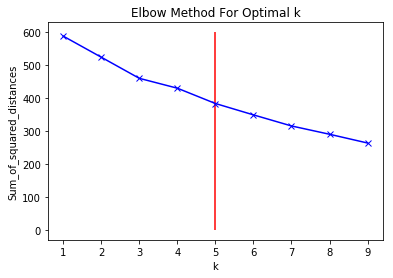

In [85]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.vlines(5, ymin = 0, ymax = 600, colors = 'red')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

the number of cluster, k is 5.

__2. SILHOUTE COEFFICIENT__
To find the optimal value of the number of clusters, k, the number of clusters is iterated corresponding Silhouette Coefficientis calculated for each of the k-values used. The highest Silhouette Coefficient gives the best match to its own cluster. Please see below:

In [86]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2,6):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.23410935143769684
Where n_clusters = 3, the Silhouette Coefficient is 0.1997934491186046
Where n_clusters = 4, the Silhouette Coefficient is 0.1993107584270363
Where n_clusters = 5, the Silhouette Coefficient is 0.23768299742628793


In [87]:
clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [88]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clusters['Latitude'], clusters['Longitude'], clusters['Location'], clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

__CLUSTER 1__

In [89]:
clusters.loc[clusters['Cluster Labels'] == 0, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Newham,0,Hotel,Bar,Scenic Lookout,Coffee Shop,Burger Joint,Golf Driving Range,Music Venue,Pier,Multiplex,Movie Theater
35,Newham,0,Coffee Shop,Hotel,Indian Restaurant,Park,Clothing Store,Diner,Gym,Pub,Sandwich Place,Supermarket
36,Newham,0,Coffee Shop,Hotel,Indian Restaurant,Park,Clothing Store,Diner,Gym,Pub,Sandwich Place,Supermarket
37,Newham,0,Coffee Shop,Hotel,Indian Restaurant,Park,Clothing Store,Diner,Gym,Pub,Sandwich Place,Supermarket
45,Newham,0,Hotel,Bar,Scenic Lookout,Coffee Shop,Burger Joint,Golf Driving Range,Music Venue,Pier,Multiplex,Movie Theater
50,Newham,0,Hotel,Bar,Scenic Lookout,Coffee Shop,Burger Joint,Golf Driving Range,Music Venue,Pier,Multiplex,Movie Theater
69,Newham,0,Hotel,Bar,Scenic Lookout,Coffee Shop,Burger Joint,Golf Driving Range,Music Venue,Pier,Multiplex,Movie Theater


## CLUSTER 2

In [90]:
clusters.loc[clusters['Cluster Labels'] == 1, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Barnet,1,Café,Coffee Shop,Forest,Pub,Bakery,Greek Restaurant,Movie Theater,Park,Pizza Place,Italian Restaurant
4,Barnet,1,Café,Coffee Shop,Forest,Pub,Bakery,Greek Restaurant,Movie Theater,Park,Pizza Place,Italian Restaurant
7,Barnet,1,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Café,Park,Gym,Indian Restaurant,Bakery,Golf Course
8,Barnet,1,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Café,Park,Gym,Indian Restaurant,Bakery,Golf Course
11,Barnet,1,Coffee Shop,Café,Pub,Indian Restaurant,Forest,French Restaurant,Italian Restaurant,Deli / Bodega,Playground,Park
13,Barnet,1,Coffee Shop,Café,Turkish Restaurant,Pub,Italian Restaurant,Indian Restaurant,Park,Supermarket,Middle Eastern Restaurant,Gym / Fitness Center
14,Barnet,1,Coffee Shop,Café,Turkish Restaurant,Pub,Italian Restaurant,Indian Restaurant,Park,Supermarket,Middle Eastern Restaurant,Gym / Fitness Center
15,Barnet,1,Coffee Shop,Café,Turkish Restaurant,Pub,Italian Restaurant,Indian Restaurant,Park,Supermarket,Middle Eastern Restaurant,Gym / Fitness Center
17,Barnet,1,Café,Coffee Shop,Greek Restaurant,Park,Italian Restaurant,Pub,Gourmet Shop,Convenience Store,Restaurant,Garden Center
20,Hounslow,1,Café,Coffee Shop,Bakery,Pub,Bookstore,Hotel,Organic Grocery,Pizza Place,Playground,Ice Cream Shop


### CLUSTER 3

In [91]:
clusters.loc[clusters['Cluster Labels'] == 2, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Barnet,2,Gym / Fitness Center,Pet Store,Hotel,Pub,Chinese Restaurant,Supermarket,Café,Spa,Pizza Place,Portuguese Restaurant
6,Brent,2,Park,Grocery Store,Chinese Restaurant,Burger Joint,Pub,Italian Restaurant,Café,Portuguese Restaurant,Furniture / Home Store,Restaurant
18,Barnet,2,Park,Grocery Store,Turkish Restaurant,Bakery,Italian Restaurant,Sushi Restaurant,Coffee Shop,Zoo,Falafel Restaurant,Ice Cream Shop
19,Barnet,2,Gym / Fitness Center,Pet Store,Hotel,Pub,Chinese Restaurant,Supermarket,Café,Spa,Pizza Place,Portuguese Restaurant
22,Barnet,2,Grocery Store,Pub,Golf Course,Indian Restaurant,Farm,Pharmacy,Pizza Place,Platform,Gastropub,Coffee Shop
24,Ealing,2,Park,Hotel,Indian Restaurant,Persian Restaurant,Bar,Café,Brewery,Fish & Chips Shop,Indie Movie Theater,Pub
26,Barnet,2,Grocery Store,Pub,Department Store,Gym / Fitness Center,Park,Café,Gastropub,Rugby Stadium,Coffee Shop,Portuguese Restaurant
29,Barnet,2,Gym / Fitness Center,Pet Store,Hotel,Pub,Chinese Restaurant,Supermarket,Café,Spa,Pizza Place,Portuguese Restaurant
32,Brent,2,Gym / Fitness Center,Pet Store,Hotel,Pub,Chinese Restaurant,Supermarket,Café,Spa,Pizza Place,Portuguese Restaurant
38,Newham,2,Park,Café,Dessert Shop,Grocery Store,Men's Store,Pool,Clothing Store,Lingerie Store,Furniture / Home Store,Movie Theater


### CLUSTER 4

In [92]:
clusters.loc[clusters['Cluster Labels'] == 3, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Newham,3,Indian Restaurant,Park,Coffee Shop,Pub,Pet Store,Sandwich Place,Diner,Hotel,Pizza Place,Discount Store
16,Newham,3,Indian Restaurant,Park,Pub,Bar,Restaurant,Grocery Store,Hotel,Café,Portuguese Restaurant,Movie Theater
33,Newham,3,Indian Restaurant,Clothing Store,Pub,Gym / Fitness Center,Park,Coffee Shop,Irish Pub,Grocery Store,Movie Theater,Fast Food Restaurant
34,Newham,3,Indian Restaurant,Clothing Store,Pub,Gym / Fitness Center,Park,Coffee Shop,Irish Pub,Grocery Store,Movie Theater,Fast Food Restaurant
54,Newham,3,Indian Restaurant,Pub,Park,Coffee Shop,Grocery Store,Bakery,Pizza Place,Ice Cream Shop,Toy / Game Store,Shopping Mall
55,Newham,3,Indian Restaurant,Pub,Park,Coffee Shop,Grocery Store,Bakery,Pizza Place,Ice Cream Shop,Toy / Game Store,Shopping Mall


### CLUSTER 5

In [93]:
clusters.loc[clusters['Cluster Labels'] == 4, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brent,4,Café,Coffee Shop,Turkish Restaurant,Middle Eastern Restaurant,Pub,Gym / Fitness Center,Park,Supermarket,Grocery Store,Movie Theater
1,Barnet,4,Café,Coffee Shop,Turkish Restaurant,Middle Eastern Restaurant,Pub,Gym / Fitness Center,Park,Supermarket,Grocery Store,Movie Theater
9,Ealing,4,Pub,Coffee Shop,Pizza Place,Hotel,Park,Café,Bakery,Theater,Salad Place,Bistro
10,Ealing,4,Pub,Coffee Shop,Pizza Place,Hotel,Park,Café,Bakery,Theater,Salad Place,Bistro
25,Brent,4,Pub,Middle Eastern Restaurant,Movie Theater,Coffee Shop,Café,Hookah Bar,Lebanese Restaurant,Fast Food Restaurant,Pizza Place,Hotel
30,Brent,4,Pub,Middle Eastern Restaurant,Café,Thai Restaurant,Indian Restaurant,Brazilian Restaurant,Pizza Place,Coffee Shop,Park,Supermarket
31,Brent,4,Pub,Middle Eastern Restaurant,Café,Thai Restaurant,Indian Restaurant,Brazilian Restaurant,Pizza Place,Coffee Shop,Park,Supermarket
40,Brent,4,Pub,Grocery Store,Park,Café,Middle Eastern Restaurant,Coffee Shop,Chinese Restaurant,Italian Restaurant,Gym / Fitness Center,Deli / Bodega
41,Brent,4,Pub,Grocery Store,Park,Café,Middle Eastern Restaurant,Coffee Shop,Chinese Restaurant,Italian Restaurant,Gym / Fitness Center,Deli / Bodega
46,Barnet,4,Pub,Coffee Shop,Park,Turkish Restaurant,Italian Restaurant,Grocery Store,Pharmacy,Pizza Place,Fish & Chips Shop,Movie Theater


# 4. RESULT

__HIGHLIGHTS FROM ABOVE 5 CLUSTERS__

1. Pubs, Cafe, Coffee Shops are popular in the London.
2. As for restaurants, the Italian Restaurants are very popular in the  London.
3. Although, the Clusters have variations, a very visible presence is the dominance of pubs.

_We conclude from above observation that CLUSTERS 3 and 5 are scarce in terms of availability of INDIAN RESTAURANTS_

Hence, above two mentioned clusters are suitable for opening a new INDIAN RESTAURANT

# 5. DISCUSSION AND CONCLUSION

It is very important to note that Clusters 3 and 5 are the most viable clusters to create a __INDIAN RESTAURANT__. Their proximity to other amenities and accessibility to INDIAN PEOPLE are paramount. These 2 _clusters do not have top restaurants that could rival their standards_ if they are created.

In conclusion, this project would have had better results if there were more data in terms of crime data within the area, traffic access and allowance of more venues exploration with the Foursquare (limited venues for free calls).

Also, getting the ratings and feedbacks of the current restaurants within the clusters would have helped in providing more insight into the best location.